# E‑commerce Product Return Analysis & Prediction
Author: 

This notebook loads four CSV files (`distribution_center.csv`, `order_items.csv`, `products.csv`, `users.csv`) to:
1. Explore which **gender**, **age**, **country**, **distribution center**, and **product category** have the highest return rates, with visualizations.
2. Create a cleaned feature set and save it to `returns_features.csv`.
3. Train a baseline **Logistic Regression** model (plus optional XGBoost) to predict product returns.

---
**Directory setup**: place the CSVs in the same folder as this notebook _or_ adjust the paths in the first code cell.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- File paths (edit if needed) ----
path_dc  = Path('thelook_ecommerce.distribution_centers.csv')
path_ord = Path('thelook_ecommerce.order_items.csv')
path_prod = Path('thelook_ecommerce.products.csv')
path_users = Path('thelook_ecommerce.users.csv')



# ---- Load data ----
dc   = pd.read_csv(path_dc)
orders = pd.read_csv(path_ord, parse_dates=['created_at', 'shipped_at', 'delivered_at', 'returned_at'])
products = pd.read_csv(path_prod)
users = pd.read_csv(path_users)

print('Data loaded:')
for name, df in [('Distribution centers', dc), ('Orders', orders),
                 ('Products', products), ('Users', users)]:
    print(f'{name}:', df.shape)


Data loaded:
Distribution centers: (10, 4)
Orders: (180952, 11)
Products: (29120, 9)
Users: (100000, 15)


In [10]:
# ---- Peek at 4 rows from each table ----
print("Distribution_centers (4 rows):")
display(dc.head(4))

print("\nOrder_items (4 rows):")
display(orders.head(4))

print("\nProducts (4 rows):")
display(products.head(4))

print("\nUsers (4 rows):")
display(users.head(4))

Distribution_centers (4 rows):


,id,name,latitude,longitude
0,1,Memphis TN,35.1174,-89.9711
1,2,Chicago IL,41.8369,-87.6847
2,3,Houston TX,29.7604,-95.3698
3,4,Los Angeles CA,34.0500,-118.2500



Order_items (4 rows):


,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,15721,10826,8614,13606,42278,Shipped,2020-06-28 00:40:17 UTC,2020-06-29 04:40:00 UTC,NaN,NaN,2.5
1,19167,13243,10505,13606,51560,Shipped,2022-03-01 05:18:44 UTC,2022-03-01 20:48:00 UTC,NaN,NaN,2.5
2,77007,53140,42340,13606,207367,Shipped,2021-04-11 01:31:52 UTC,2021-04-14 00:32:00 UTC,NaN,NaN,2.5
3,151639,104681,83704,13606,408715,Shipped,2022-03-29 21:37:06 UTC,2022-03-30 12:41:00 UTC,NaN,NaN,2.5



Products (4 rows):


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,27569,92.652563,Swim,2XU Men's Swimmers Compression Long Sleeve Top,2XU,150.410004,Men,B23C5765E165D83AA924FA8F13C05F25,1
1,27445,24.719661,Swim,TYR Sport Men's Square Leg Short Swim Suit,TYR,38.990002,Men,2AB7D3B23574C3DEA2BD278AFD0939AB,1
2,27457,15.897600,Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.600000,Men,8F831227B0EB6C6D09A0555531365933,1
3,27466,17.850000,Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.000000,Men,67317D6DCC4CB778AEB9219565F5456B,1



Users (4 rows):


,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,44262,Michael,Sanchez,michaelsanchez@example.net,48,M,Mie,5379 Kim Corner,513-0836,Suzuka City,Japan,34.851814,136.508713,Facebook,2020-12-05 14:39:00 UTC
1,61852,David,Watson,davidwatson@example.org,21,M,Mie,58568 Brooks Plain Apt. 269,513-0836,Suzuka City,Japan,34.851814,136.508713,Search,2022-01-24 13:00:00 UTC
2,82418,Lisa,Rivera,lisarivera@example.net,29,F,Mie,3092 Perez Overpass,513-0836,Suzuka City,Japan,34.851814,136.508713,Search,2019-09-07 07:29:00 UTC
3,23274,Logan,Flores,loganflores@example.com,53,M,Acre,412 Underwood Tunnel Suite 025,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-06-28 14:39:00 UTC


In [11]:
# ---- Create RETURN flag ----
orders['RETURN_FLAG'] = orders['returned_at'].notna().astype(int)

# ---- Merge tables ----
df = (orders
      .merge(products[['id', 'category', 'distribution_center_id']], left_on='product_id', right_on='id', how='left', suffixes=('', '_prod'))
      .merge(users[['id', 'gender', 'age', 'country']], left_on='user_id', right_on='id', how='left', suffixes=('', '_user'))
      .merge(dc.rename(columns={'id':'distribution_center_id'}), on='distribution_center_id', how='left'))

# Clean up duplicate id columns
df.drop(columns=['id_prod', 'id_user'], inplace=True)

print('Merged dataset:', df.shape)
df.head()

Merged dataset: (180952, 20)


,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,RETURN_FLAG,category,distribution_center_id,gender,age,country,name,latitude,longitude
0,15721,10826,8614,13606,42278,Shipped,2020-06-28 00:40:17 UTC,2020-06-29 04:40:00 UTC,NaN,NaN,2.5,0,Accessories,3,F,24,Brasil,Houston TX,29.7604,-95.3698
1,19167,13243,10505,13606,51560,Shipped,2022-03-01 05:18:44 UTC,2022-03-01 20:48:00 UTC,NaN,NaN,2.5,0,Accessories,3,F,23,Brasil,Houston TX,29.7604,-95.3698
2,77007,53140,42340,13606,207367,Shipped,2021-04-11 01:31:52 UTC,2021-04-14 00:32:00 UTC,NaN,NaN,2.5,0,Accessories,3,F,59,China,Houston TX,29.7604,-95.3698
3,151639,104681,83704,13606,408715,Shipped,2022-03-29 21:37:06 UTC,2022-03-30 12:41:00 UTC,NaN,NaN,2.5,0,Accessories,3,F,41,United States,Houston TX,29.7604,-95.3698
4,170817,117931,94363,13606,460556,Shipped,2021-02-17 09:28:17 UTC,2021-02-19 19:03:00 UTC,NaN,NaN,2.5,0,Accessories,3,F,18,China,Houston TX,29.7604,-95.3698


## 1️⃣ Exploratory Data Analysis
Below we visualize return rates across the requested dimensions.

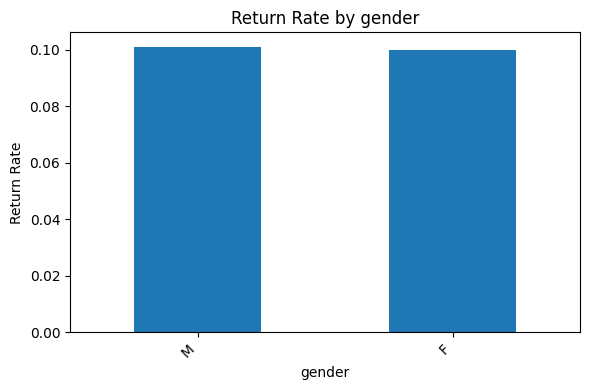

/var/folders/d3/vskdykq51ls6y387np4y9flr0000gn/T/ipykernel_10194/3734493887.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby(col)['RETURN_FLAG'].mean().sort_values(ascending=False)


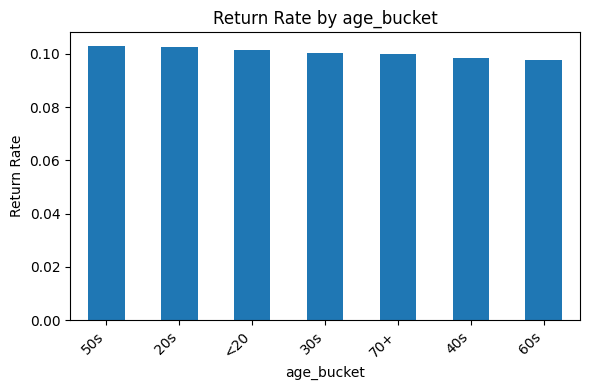

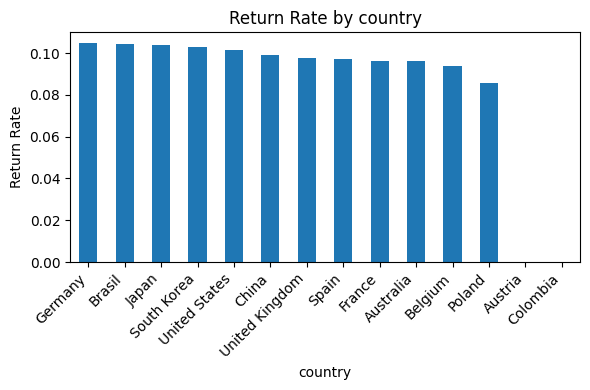

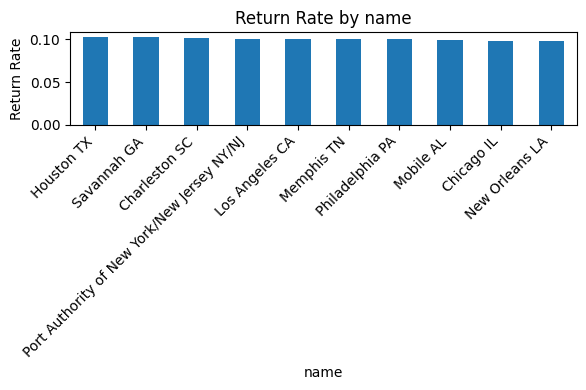

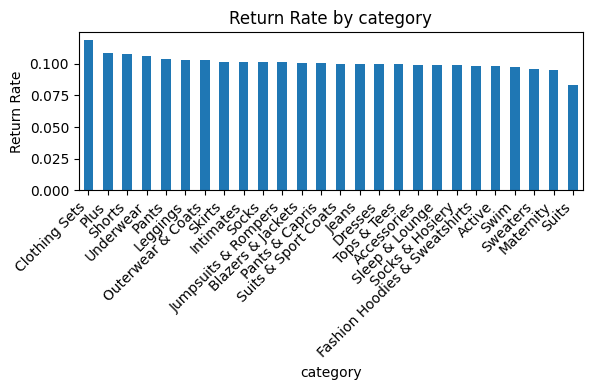

In [12]:
def plot_return_rate(col, figsize=(6,4)):
    rates = df.groupby(col)['RETURN_FLAG'].mean().sort_values(ascending=False)
    plt.figure(figsize=figsize)
    rates.plot(kind='bar')
    plt.ylabel('Return Rate')
    plt.title(f'Return Rate by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Gender
plot_return_rate('gender')
# Age buckets (decades)
df['age_bucket'] = pd.cut(df['age'], bins=[0,19,29,39,49,59,69,120], labels=['<20','20s','30s','40s','50s','60s','70+'])
plot_return_rate('age_bucket')
# Country
plot_return_rate('country')
# Distribution center
plot_return_rate('name')  # name column from dc table
# Product category
plot_return_rate('category')

## 2️⃣ Feature Engineering & Export
We keep the requested features and encode the target as 0/1.

In [13]:
feature_cols = ['gender', 'age', 'country', 'distribution_center_id', 'category', 'RETURN_FLAG']
feat_df = df[feature_cols].dropna()
# Save to CSV
feat_path = Path('returns_features.csv')
feat_df.to_csv(feat_path, index=False)
print(f'Feature dataset saved to {feat_path.resolve()} with shape {feat_df.shape}')

Feature dataset saved to /Users/pyaelinn/Desktop/cdsp_linn/ET6-CDSP-group-17-repo-Mission_Impostible/4_data_analysis/returns_features.csv with shape (180952, 6)


## 3️⃣ Predictive Modeling
Baseline: **Logistic Regression** with one‑hot encoding for categorical variables.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Separate features / target
X = feat_df.drop(columns=['RETURN_FLAG'])
y = feat_df['RETURN_FLAG']

# Identify categorical & numeric cols
cat_cols = ['gender', 'country', 'distribution_center_id', 'category']
num_cols = ['age']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

model = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('ROC‑AUC:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

### 🔍 Recommended Additional Features
- **Time-based**: `created_at` weekday/weekend, month, season
- **Price**: `sale_price` vs MSRP, discount percentage
- **Shipping latency**: days between `created_at` and `shipped_at`
- **User tenure**: days since `users.created_at`
- **Product cost**: `cost` from products table
- **Department**: broader grouping of categories
- **Traffic source**: from `users.traffic_source` (marketing channel)

Adding these may improve model performance.